# NFL Database Exploratory Data Analysis (EDA)
This notebook explores key trends and insights in the NFL database, focusing on team performance, player statistics, and the influence of weather on games.

Going to start specifically investigating the complete 2023 regular season. 


In [17]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os

In [13]:
%load_ext sql
conn = sqlite3.connect('..\\nfl_fantasy.db')
cursor = conn.cursor()
%sql sqlite:///C:\Users\Jrdes\Desktop\NFL\NFL-Analytics\nfl_fantasy.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## NFL Team Wins throughout the 2023 Regular Season

Run query to capture game results throughout 2023 regular season and plot into line chart

In [70]:
%%sql results <<

SELECT G.GAME_ID,
       G.GAME_WEEK,
       G.GAME_DATE,
       G.GAME_TYPE,
       G.HOME_TEAM,
       G.AWAY_TEAM,
       T.ABBREVIATION AS WINNING_TEAM
FROM Game G
JOIN Team T
ON G.WINNING_TEAM_ID = T.TEAM_ID
WHERE G.SEASON_ID = 2023
AND G.GAME_TYPE = 'Regular Season';

 * sqlite:///C:\Users\Jrdes\Desktop\NFL\NFL-Analytics\nfl_fantasy.db
Done.
Returning data to local variable results


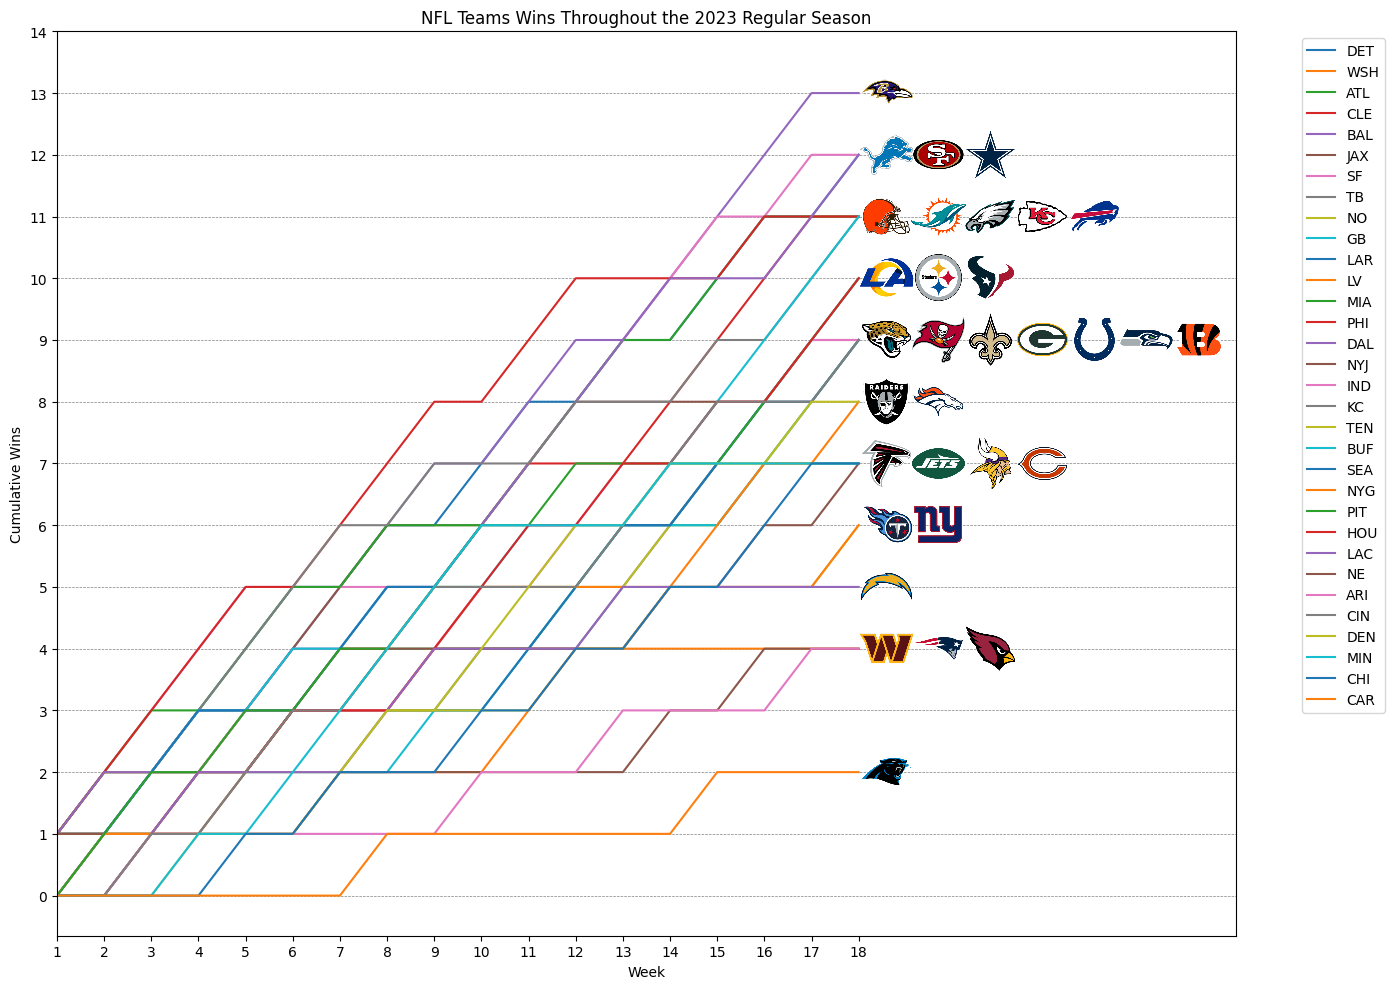

In [71]:
regular_season_results_df = results.DataFrame()

# Remove 'Week' from GAME_WEEK column (e.g., 'Week 1' > 1)
regular_season_results_df['GAME_WEEK'] = regular_season_results_df['GAME_WEEK'].apply(lambda x: int(x.split()[1]))

# Initialize an empty dataframe to store wins per team per week
teams = regular_season_results_df['WINNING_TEAM'].unique()
weeks = regular_season_results_df['GAME_WEEK'].unique()

# Create a wins dictionary
wins_per_week = {team: [0] * len(weeks) for team in teams}

# Count wins per team per week
for week in weeks:
    weekly_games = regular_season_results_df[regular_season_results_df['GAME_WEEK'] == week]
    for team in weekly_games['WINNING_TEAM']:
        wins_per_week[team][week - 1] += 1

# Accumulate the wins week by week (cumulative wins)
for team in teams:
    wins_per_week[team] = pd.Series(wins_per_week[team]).cumsum()

# Function to add image (team logo) next to the final point of each line
def add_logo(ax, img_path, x, y, offset_x):
    img = Image.open(img_path)
    imagebox = OffsetImage(img, zoom=0.14)  # Adjust zoom level for logos
    ab = AnnotationBbox(imagebox, (x + offset_x, y), frameon=False, xybox=(20, 0), xycoords='data',
                        boxcoords="offset points", pad=0)
    ax.add_artist(ab)

# Plotting
fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the figure size for more space

# Add horizontal gridlines for number of wins
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='gray')  # Dashed gray lines

logo_offsets = {}
for team, wins in wins_per_week.items():
    ax.plot(weeks, wins, label=team)

    # Get the last week's win count for each team
    last_week = weeks[-1]
    last_win_count = wins.iloc[-1]  # Ensure you're using iloc for the last value

    # Path to the team's logo in 'nfl-logos' folder
    logo_path = f'../../nfl-logos/{team}.png'
    
    if os.path.exists(logo_path):
        # Handle overlapping logos: if another team has the same win count, increase the offset
        if last_win_count in logo_offsets:
            offset_x = logo_offsets[last_win_count] * 1.1  # Increment offset for each same win count
            logo_offsets[last_win_count] += 1
        else:
            offset_x = 0
            logo_offsets[last_win_count] = 1  # Initialize offset for this win count
        
        # Add the logo with an offset
        add_logo(ax, logo_path, last_week, last_win_count, offset_x)

# Adjust x-axis limits to give extra room for logos
plt.xlim(1, weeks[-1] + 8)  # Extending the x-axis by 2 units to the right for logos

# Labeling and formatting the chart
plt.xlabel('Week')
plt.ylabel('Cumulative Wins')
plt.title('NFL Teams Wins Throughout the 2023 Regular Season')
plt.xticks(weeks)  # Set the x-axis ticks to be the weeks
plt.yticks(range(0,15))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.tight_layout()
plt.show()

Want to split up each team into an organized query highlighting their:
- Wins
- Losses
- Home Record
- Away Record
- Divisional Record


In [80]:
%%sql
SELECT
    t.ABBREVIATION AS TEAM,
    t.DIVISION AS DIVISION,
    
    -- Total Wins (W)
    SUM(CASE WHEN g.WINNING_TEAM_ID = t.TEAM_ID THEN 1 ELSE 0 END) AS W,
    
    -- Total Losses (L) = Total games played - wins
    SUM(CASE WHEN g.HOME_TEAM_ID = t.TEAM_ID OR g.AWAY_TEAM_ID = t.TEAM_ID THEN 1 ELSE 0 END) 
    - SUM(CASE WHEN g.WINNING_TEAM_ID = t.TEAM_ID THEN 1 ELSE 0 END) AS L,
    
    -- Win Percentage (WIN_PCT)
    ROUND(
        CAST(SUM(CASE WHEN g.WINNING_TEAM_ID = t.TEAM_ID THEN 1 ELSE 0 END) AS REAL)
        / NULLIF(SUM(CASE WHEN g.HOME_TEAM_ID = t.TEAM_ID OR g.AWAY_TEAM_ID = t.TEAM_ID THEN 1 ELSE 0 END), 0), 3) AS WIN_PCT,

    -- Home Record (Wins-Losses)
    SUM(CASE WHEN g.HOME_TEAM_ID = t.TEAM_ID AND g.WINNING_TEAM_ID = t.TEAM_ID THEN 1 ELSE 0 END) 
    || '-' || 
    SUM(CASE WHEN g.HOME_TEAM_ID = t.TEAM_ID AND g.WINNING_TEAM_ID != t.TEAM_ID THEN 1 ELSE 0 END) AS HOME_RECORD,
    
    -- Away Record (Wins-Losses)
    SUM(CASE WHEN g.AWAY_TEAM_ID = t.TEAM_ID AND g.WINNING_TEAM_ID = t.TEAM_ID THEN 1 ELSE 0 END) 
    || '-' || 
    SUM(CASE WHEN g.AWAY_TEAM_ID = t.TEAM_ID AND g.WINNING_TEAM_ID != t.TEAM_ID THEN 1 ELSE 0 END) AS AWAY_RECORD,

    -- Division Record (Wins-Losses)
    SUM(CASE
        -- Division wins
        WHEN g.WINNING_TEAM_ID = t.TEAM_ID AND (
            (g.HOME_TEAM_ID = t.TEAM_ID AND t.DIVISION = at.DIVISION) OR
            (g.AWAY_TEAM_ID = t.TEAM_ID AND t.DIVISION = ht.DIVISION)
        ) THEN 1 ELSE 0 END)
    || '-' ||
    SUM(CASE
        -- Division losses
        WHEN g.WINNING_TEAM_ID != t.TEAM_ID AND (
            (g.HOME_TEAM_ID = t.TEAM_ID AND t.DIVISION = at.DIVISION) OR
            (g.AWAY_TEAM_ID = t.TEAM_ID AND t.DIVISION = ht.DIVISION)
        ) THEN 1 ELSE 0 END) AS DIV_RECORD

FROM
    Team t
    LEFT JOIN Game g ON g.HOME_TEAM_ID = t.TEAM_ID OR g.AWAY_TEAM_ID = t.TEAM_ID
    LEFT JOIN Team ht ON g.HOME_TEAM_ID = ht.TEAM_ID -- Home Team Alias for Division Check
    LEFT JOIN Team at ON g.AWAY_TEAM_ID = at.TEAM_ID -- Away Team Alias for Division Check

-- Filtering for Regular Season and the 2023 Season
WHERE
    g.GAME_TYPE = 'Regular Season'
    AND g.SEASON_ID = '2023'

GROUP BY
    t.ABBREVIATION
ORDER BY
    DIVISION ASC;




 * sqlite:///C:\Users\Jrdes\Desktop\NFL\NFL-Analytics\nfl_fantasy.db
Done.


TEAM,DIVISION,W,L,WIN_PCT,HOME_RECORD,AWAY_RECORD,DIV_RECORD
BUF,AFC East,11,6,0.647,7-2,4-4,4-2
MIA,AFC East,11,6,0.647,7-2,4-4,4-2
NE,AFC East,4,13,0.235,1-8,3-5,2-4
NYJ,AFC East,7,10,0.412,4-5,3-5,2-4
BAL,AFC North,13,4,0.765,6-3,7-1,3-3
CIN,AFC North,9,8,0.529,6-3,3-5,1-5
CLE,AFC North,11,6,0.647,8-1,3-5,3-3
PIT,AFC North,10,7,0.588,5-4,5-3,5-1
HOU,AFC South,10,7,0.588,6-3,4-4,4-2
IND,AFC South,9,8,0.529,4-5,5-3,3-3
